![alt text](assets/p_hd_method.png "Title")

In [0]:
import numpy as np

# dimensionality
D = 2

# wall length of the cube
L = 22

# number of place cells
N = 5

# number of head direction cells
M = 4

#TODO figure out scalars
# place cell scale -- positive scalar fixed before experiment
SIGMA_c = 1

# head direction concentration parameter -- positive scalar fixed before experiment
K_h = 1

# uniform distribution of place cell centers  
PC_CENTERS = np.random.uniform(0,L,[N,D])

# uniform distribution of head direction cell centers  
HDC_CENTERS = np.random.uniform(-np.pi,np.pi,M)
'''
Place Cell Activations 
input
    x : vector in R^D
output
    c : vector in [0,1]^N
'''
def c(x):
    assert x.shape[0] == D
    # each top term -- note: np.array([x,]*N)-PC_CENTERS <=> x-PC_CENTERS
    iso_gaus_N = np.exp(-np.square(x-PC_CENTERS).sum(axis=1)/(2*SIGMA_c)**2)
    # normalize
    return iso_gaus_N/iso_gaus_N.sum()

'''
Head Direction Cell Activations 
input
    rho : scalar in R
output
    h : vector in [0,1]^M
'''
def h(rho):
    # each top term
    von_mises_M = np.exp(K_h*np.cos(rho-HDC_CENTERS))
    # normalize
    return von_mises_M/von_mises_M.sum()
    
# random input x
x = np.random.rand(3)
c(np.array([1,2]))
h(np.array([1]))

'''
In the supervised setup the grid cell network receives, at each step t,
the egocentric linear velocity v_t in R and the sine and cosine of its angular velocity rho_t.

The recurrent LSTM layer consists of one cell of 128 hidden units, with no peephole connections.
Input to the recurrent LSTM layer is the vector [v_t, sin(rho_t), cos(rho_t)]
TODO: should add the vertical angle too
'''
x

array([0.78906977, 0.67154109, 0.46087009])

In [0]:
x.shape

(3,)

In [0]:
1-HDC_CENTERS

array([-0.88142434, -0.11586202,  0.49776447,  1.97955437])

In [0]:
x-PC_CENTERS

ValueError: ignored

In [0]:
np.array([x,]*N)-PC_CENTERS

ValueError: ignored

![alt text](assets/rat_trajectory.png "Title")

In [0]:
import numpy as np
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

maps = {
    'circularCage': {'b': 16.44, 'mu': 0.31, 'sigma': 355.35},
    'squareCage': {'b': 13.02, 'mu': -0.03, 'sigma': 330.12},
    'squareCageWithWall': {'b': 12.95, 'mu': 1.89, 'sigma': 331.07}
}

def unit_vector(vector):
    """ Returns the unit vector of the vector."""
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """Finds angle between two vectors"""
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

def y_rotation(vector,theta):
    """Rotates 3-D vector around y-axis"""
    R = np.array([[np.cos(theta),0,np.sin(theta)],[0,1,0],[-np.sin(theta), 0, np.cos(theta)]])
    return np.dot(R,vector)

def shortest_distance(x1, y1, a, b, c):  
    d = abs((a * x1 + b * y1 + c)) / (math.sqrt(a * a + b * b)) 
    print("Perpendicular distance is"),d 

# def angle(v1, v2, acute):
# # v1 is your firsr vector
# # v2 is your second vector
#     angle = np.arccos(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))
#     if (acute == True):
#         return angle
#     else:
#         return 2 * np.pi - angle

 
def angle(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'    """
    angle = np.arctan2(v2[2], v2[0]) - np.arctan2(v1[2], v1[0])
    if angle > np.pi:
      angle -= 2*np.pi
    elif angle <= -np.pi:
      angle += 2*np.pi
    return angle

def min_dist_angle(prev_position, direction, up, scene):
    if scene[0] != 'squareCage' and scene[0] != 'squareCageWithWall':
        return
    
    # length of the cage
    L = scene[1]
    
    # Perpendicular distance to line 
    # Southern Wall z = 0
    s_dist = prev_position[2]
    # Northern Wall z = L
    n_dist = L - prev_position[2]
    # Western Wall x = 0
    w_dist = prev_position[0]
    # Eastern Wall x = L
    e_dist = L - prev_position[0]
    
    wall_dists = [s_dist, n_dist, w_dist, e_dist]
    
    min_pos = np.argmin(wall_dists)
    
    dWall = wall_dists[min_pos]
    
    west_wall = [-1, 0, 0]

    north_wall = [0, 0, 1]

    east_wall = [1, 0, 0]

    south_wall = [0, 0, -1]
    
    walls = [south_wall, north_wall, west_wall, east_wall]
    aWall = angle(direction, walls[min_pos])
    return [dWall, aWall]
    

# PSEUDO CODE HERE https://ibb.co/VNvwC7Y
    
def generate_rat_trajectory(scene, samples):
    """
    scene - contains a description of the environment 
    samples - number of samples
    ---
    position - (samples,3)-shaped matrix holding the 3-dim positions overtime
    velocity - (samples,3)-shaped matrix holding the 3-dim velocities overtime
    """
    
    # Initialize parameters for velocity and camera
    v = 20
    dirr = np.array([0, 0, 1])
    up = np.array([0, 1, 0])
    dt = 0.02

    L = scene[1]
    
    # create random velocity samples
    random_turn = np.radians(np.random.normal(maps[scene[0]]['mu'], maps[scene[0]]['sigma'], samples))
    # print(random_turn)
    random_velocity = np.random.rayleigh(maps[scene[0]]['b'], samples)
    
    # allocate memory for x, y, and z-components of position and velocity
    position_matrix = np.zeros((samples, 3))
    position_matrix[0] = L*np.random.rand(3) # initialize
    velocity_matrix = np.zeros((samples, 3))
    
    for step in range(1, samples):
        # computes the min distance and corresponding angle for a position
        [dWall, aWall] = min_dist_angle(position_matrix[step-1], dirr, up, scene)

        # update speed and turn angle 
        if dWall<2 and np.absolute(aWall)<np.pi/2:
            # print('oups')
            angle = aWall/np.absolute(aWall)*(np.pi-np.absolute(aWall)) + random_turn[step]
            v = v-0.5*(v-5) # slow down
        else:
            v = random_velocity[step]
            angle = random_turn[step]
        
        low = np.array([0,0,0])
        high = np.array([L,L,L])
        # move.
        position_matrix[step] = np.minimum(np.maximum(position_matrix[step-1] + dirr*v*dt, low), high)
        velocity_matrix[step] = dirr*v*dt
        
        # turn the 3D direction vector around y-axis
        dirr = y_rotation(dirr, angle*dt)
    
    return [position_matrix, velocity_matrix]

In [23]:
np.degrees(angle([0,0,1],[0,0,0]))

-90.0

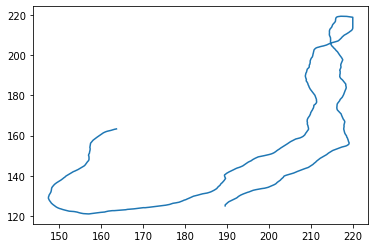

In [27]:
[position_matrix, velocity_matrix] = generate_rat_trajectory(['squareCage', 220],1000) # 220 cm, 100 samples
plt.plot(position_matrix[:,0], position_matrix[:,2])
plt.show()

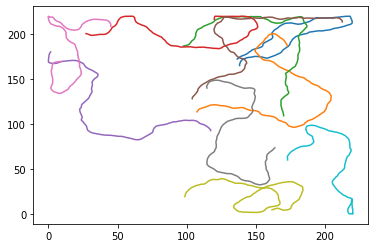

In [28]:
for _ in range(10):
  [position_matrix, velocity_matrix] = generate_rat_trajectory(['squareCage', 220],750) # 220 cm, 100 samples
  plt.plot(position_matrix[:,0], position_matrix[:,2])
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:122: RuntimeWarning: invalid value encountered in double_scalars


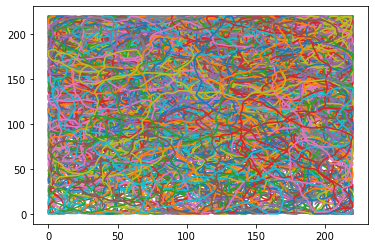

In [29]:
for _ in range(1000):
  [position_matrix, velocity_matrix] = generate_rat_trajectory(['squareCage', 220],750) # 220 cm, 100 samples
  plt.plot(position_matrix[:,0], position_matrix[:,2])
plt.show()

In [0]:
750*0.02

15.0

In [0]:
def min_dist_angle(prev_position, direction, up, scene):
    if scene[0] != 'squareCage' and scene[0] != 'squareCageWithWall':
        return
    
    # length of the cage
    L = scene[1]
    
    # Perpendicular distance to line 
    # Southern Wall z = 0
    s_dist = prev_position[2]
    # Northern Wall z = L
    n_dist = L - prev_position[2]
    # Western Wall x = 0
    w_dist = prev_position[0]
    # Eastern Wall x = L
    e_dist = L - prev_position[0]
    
    wall_dists = [s_dist, n_dist, w_dist, e_dist]
    
    min_pos = np.argmin(wall_dists)
    
    dWall = wall_dists[min_pos]
    
    west_wall = [-1, 0, 0]

    north_wall = [0, 0, 1]

    east_wall = [1, 0, 0]

    south_wall = [0, 0, -1]
    
    walls = [south_wall, north_wall, west_wall, east_wall]
    
    return [dWall, angle(direction, walls[min_pos], True)]

def rotation_axis(vector,theta, axis):
    """Rotates 3-D vector around axis"""
    R = np.array([[np.cos(theta),0,np.sin(theta)],axis,[-np.sin(theta), 0, np.cos(theta)]])
    return np.dot(R,vector)

  

def generate_rat_trajectory_3d(scene, samples):
    """
    scene - contains a description of the environment 
    samples - number of samples
    ---
    position - (samples,3)-shaped matrix holding the 3-dim positions overtime
    velocity - (samples,3)-shaped matrix holding the 3-dim velocities overtime
    """
    
    # Initialize parameters for velocity and camera
    v = 20
    dirr = np.array([0, 0, 1])
    up = np.array([0, 1, 0])
    dt = 0.02

    L = scene[1]
    
    # create random velocity samples
    random_turn_y = np.radians(np.random.normal(maps[scene[0]]['mu'], maps[scene[0]]['sigma'], samples))
    random_turn_z = np.radians(np.random.normal(maps[scene[0]]['mu'], maps[scene[0]]['sigma'], samples))

    # print(random_turn)
    random_velocity = np.random.rayleigh(maps[scene[0]]['b'], samples)
    
    # allocate memory for x, y, and z-components of position and velocity
    position_matrix = np.zeros((samples, 3))
    position_matrix[0] = np.array([0.2*L, 0.2*L, 0.2*L]) # initialize
    velocity_matrix = np.zeros((samples, 3))
    
    for step in range(1, samples):
        # computes the min distance and corresponding angle for a position
        [dWall, aWall] = min_dist_angle(position_matrix[step-1], dirr, up, scene)

        # update speed and turn angle 
        if dWall<2 and np.absolute(aWall)<np.pi/2:
            # print('oups')
            angle_y = aWall/np.absolute(aWall)*(np.pi-np.absolute(aWall)) + random_turn_y[step]
            angle_z = aWall/np.absolute(aWall)*(np.pi-np.absolute(aWall)) + random_turn_z[step]
            v = v-0.5*(v-5) # slow down
        else:
            v = random_velocity[step]
            angle_y = random_turn_y[step]
            angle_z = random_turn_z[step]
        
        # move.
        position_matrix[step] = position_matrix[step-1] + dirr*v*dt
        velocity_matrix[step] = dirr*v*dt
        
        # turn the 3D direction vector around y-axis
        dirr = rotation_axis(dirr, angle_y*dt, [0,1,0])

        # turn the 3D direction vector around z-axis
        dirr = rotation_axis(dirr, angle_z*dt, [0,0,1])
    
    return [position_matrix, velocity_matrix]

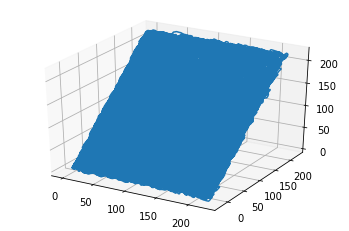

In [0]:
from mpl_toolkits.mplot3d import Axes3D
ax = plt.axes(projection='3d')

# ax.plot(x, y, z, '-b')

[position_matrix, velocity_matrix] = generate_rat_trajectory_3d(['squareCage', 220],750*750) # 220 cm, 100 samples
ax.plot(position_matrix[:,0], position_matrix[:,1], position_matrix[:,2])

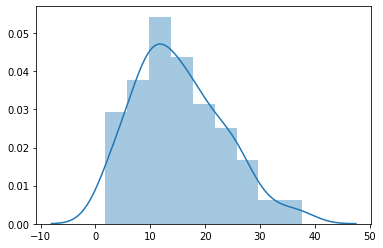

In [0]:
import seaborn as sns
sns.distplot(np.random.rayleigh(maps['squareCage']['b'], 120))


In [0]:
def angle(v1, v2, acute):
# v1 is your firsr vector
# v2 is your second vector
    angle = np.arccos(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))
    if (acute == True):
        return angle
    else:
        return 2 * np.pi - angle

In [0]:
angle(v0, v1, 'True')

NameError: name 'angle' is not defined

In [0]:
import numpy as np
import vg

vg.angle(v0, v1)

ModuleNotFoundError: No module named 'vg'

In [0]:
def angle(v1, v2, acute):
# v1 is your firsr vector
# v2 is your second vector
    angle = np.arccos(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))
    if (acute == True):
        return angle
    else:
        return 2 * np.pi - angle

vec1 = [1, -1, 0]
vec2 = [1, 1, 0]

#I am explicitly converting from radian to degree
print(180* angle(vec1, vec2, True)/np.pi) #90 degrees
print(180* angle(vec2, vec1, False)/np.pi) #270 degrees

90.0
270.0
